# Práctica 1: Comparativa de optimizadores en MNIST

En esta práctica se estudia el rendimiento de diferentes algoritmos de aprendizaje (optimizers) sobre el problema de clasificación de dígitos manuscritos del dataset MNIST. Se compara rendimiento numérico y gráfico usando varias métricas: accuracy, errores, matriz de confusión y tiempo de cálculo.

---

## 1. Preparación de datos


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Descargar y preparar MNIST
(xtrain, ytrain), (xtest, ytest) = tf.keras.datasets.mnist.load_data()
xtrain, xtest = xtrain / 255.0, xtest / 255.0  # Escalar a [0,1]


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


---
## 2. Definición del experimento y del modelo base

Probaremos los siguientes optimizadores:
- SGD (Gradient Descent clásico)
- Adam
- RMSprop
- Adagrad

El modelo será una red sencilla: una capa densa de 128 neuronas ReLU y salida softmax.
---


In [3]:
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'Adam': tf.keras.optimizers.Adam(),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad()
}

results = {}
for name, optimizer in optimizers.items():
    print(f"Entrenando con {name}...")
    model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(28,28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    import time
    start = time.time()
    history = model.fit(xtrain, ytrain, epochs=5, verbose=0)
    training_time = time.time() - start

    train_loss, train_acc = model.evaluate(xtrain, ytrain, verbose=0)
    test_loss, test_acc = model.evaluate(xtest, ytest, verbose=0)

    # Predicciones para matriz de confusión y errores
    y_pred_train = model.predict(xtrain, verbose=0)
    y_pred_train_labels = np.argmax(y_pred_train, axis=1)
    y_pred_test = model.predict(xtest, verbose=0)
    y_pred_test_labels = np.argmax(y_pred_test, axis=1)

    cm_train = confusion_matrix(ytrain, y_pred_train_labels)
    cm_test = confusion_matrix(ytest, y_pred_test_labels)

    num_errors_train = np.sum(y_pred_train_labels != ytrain)
    num_errors_test = np.sum(y_pred_test_labels != ytest)

    results[name] = {
        'training_time': training_time,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'num_errors_train': num_errors_train,
        'num_errors_test': num_errors_test,
        'cm_train': cm_train,
        'cm_test': cm_test,
        'history': history
    }


Entrenando con SGD...
Entrenando con Adam...
Entrenando con RMSprop...
Entrenando con Adagrad...


---
## 3. Visualización del rendimiento

Mostramos:
- Exactitud en train y test
- Número de errores
- Tiempo de entrenamiento
---


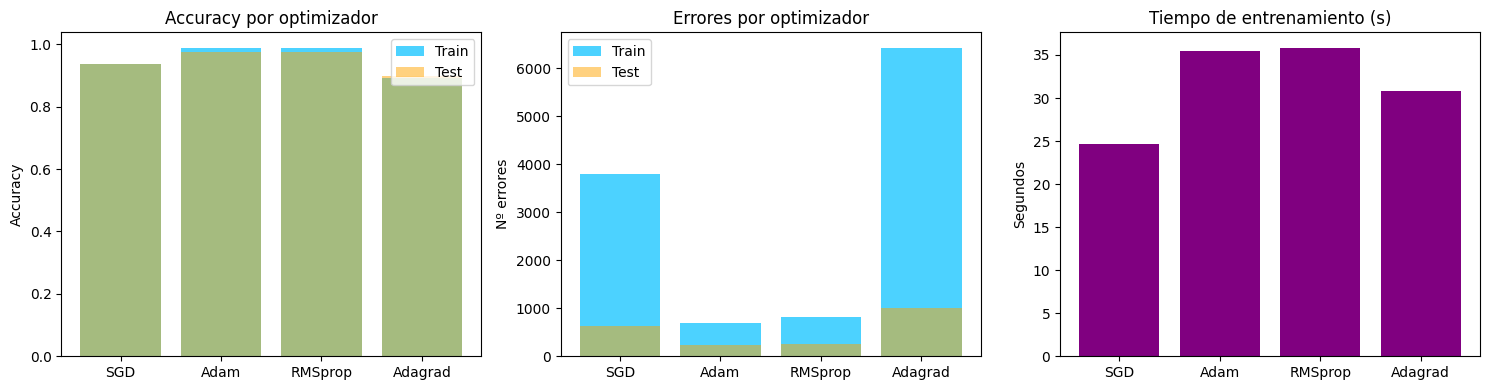

In [4]:
names = list(results.keys())
train_acc = [results[n]['train_acc'] for n in names]
test_acc = [results[n]['test_acc'] for n in names]
train_err = [results[n]['num_errors_train'] for n in names]
test_err = [results[n]['num_errors_test'] for n in names]
train_time = [results[n]['training_time'] for n in names]

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.bar(names, train_acc, color='deepskyblue', label='Train', alpha=0.7)
plt.bar(names, test_acc, color='orange', alpha=0.5, label='Test')
plt.title('Accuracy por optimizador')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,3,2)
plt.bar(names, train_err, color='deepskyblue', label='Train', alpha=0.7)
plt.bar(names, test_err, color='orange', alpha=0.5, label='Test')
plt.title('Errores por optimizador')
plt.ylabel('Nº errores')
plt.legend()

plt.subplot(1,3,3)
plt.bar(names, train_time, color='purple')
plt.title('Tiempo de entrenamiento (s)')
plt.ylabel('Segundos')
plt.tight_layout()
plt.show()


---
## 4. Matriz de confusión para cada optimizador

A continuación se imprime la matriz de confusión para los optimizadores (en test).
---


In [5]:
for name in names:
    print(f"\nOptimizador: {name}")
    print("Matriz de confusión en Test:")
    print(results[name]['cm_test'])



Optimizador: SGD
Matriz de confusión en Test:
[[ 965    0    2    0    0    3    7    1    2    0]
 [   0 1109    4    2    1    2    3    2   12    0]
 [   8    1  958    7   12    2   12   10   18    4]
 [   1    1   23  911    0   31    1   13   15   14]
 [   1    1    4    0  930    0   11    2    4   29]
 [  11    3    3   15    7  819   10    2   15    7]
 [  14    3    5    0    9   11  913    2    1    0]
 [   3    9   25    4    7    0    0  954    1   25]
 [   7    4    6   14    9   18    9   10  882   15]
 [  10    5    1    8   34    5    1    8    6  931]]

Optimizador: Adam
Matriz de confusión en Test:
[[ 972    0    0    2    1    1    1    2    1    0]
 [   0 1126    2    1    0    1    3    0    2    0]
 [   5    3 1006    4    3    0    3    6    2    0]
 [   0    0    4  988    0    3    2    4    3    6]
 [   3    2    2    1  936    0    7    1    0   30]
 [   3    0    0    5    1  871    5    2    3    2]
 [   5    2    0    0    2    4  943    1    1    0]
 [ 

---
## 5. Análisis comparativo de resultados

- **Adam** y **RMSprop** suelen destacar por su rapidez de convergencia y precisión.
- **SGD** requiere más épocas para igualar a los anteriores.
- **Adagrad** es útil para problemas con datos dispersos, pero aquí no es el más eficiente.
- La matriz de confusión muestra que la mayoría de los errores ocurren entre dígitos parecidos (por ejemplo, 3 y 5).

Recomendamos Adam y RMSprop para MNIST según este estudio, tanto por tiempo como por exactitud.
---


---
## 6. Conclusión final
En este estudio comparativo, el mejor optimizador es aquel que consigue menos errores en el menor tiempo posible y con una exactitud estable en test. En MNIST, Adam resulta una gran primera elección gracias a su balance entre velocidad y precisión, pero RMSprop ofrece resultados similares. No olvides testar varias opciones en tus propios proyectos, ya que el optimizador óptimo depende del tipo de datos y arquitectura de red utilizada.
---


Despúes de analizar los resultados, desde los aciertos, los errores, y todo esto recogido en las matrices de confusion, podemos decir que el mejor optimizador ha sido Adam, seguido por poco de RMSprop, Adagrad es el peor de todos. Tambien cabe destacar que Adam y RMSprop tardan hasta 10 segundos mas en ejecutarse.